In [ ]:
import numpy as np
import os
import glob 
import time 
import pandas as pd
import shutil
import re
import mdtraj as md
import MDAnalysis as mda
import pickle
import pickle as p 
import csv
import sys
import subprocess
import xml.etree.ElementTree as ET
import requests
import concurrent.futures
import multiprocessing
import nglview as nv
import h5py
import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.patches as patches
import html
import biobox as bb
import tempfile
import matplotlib.pyplot as plt
import molearn
import torch
import glob as glob
import MDAnalysis.analysis.rms as rms
import seaborn as sns
import pickle
import networkx as nx
sys.path.insert(0, os.path.join(os.path.abspath(os.pardir),'src'))

from Bio import PDB
from tqdm import tqdm
from time import time as t
from urllib.request import urlretrieve as download
from Bio.Blast import NCBIWWW, NCBIXML
from Bio.Blast.Applications import NcbipsiblastCommandline
from collections import defaultdict
from Bio.PDB import PPBuilder
from Bio.SeqUtils import seq1
from modeller import *
from modeller.automodel import *
from Bio.PDB import PDBParser
from MDAnalysis.analysis import align
from mpi4py import MPI
from glob import glob
from pprint import pprint as pp
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from glob import glob as g
from tqdm.notebook import tqdm
from collections import Counter
from matplotlib.ticker import FuncFormatter
from collections import defaultdict
from pymol import cmd
from scipy.interpolate import interp1d
from mpl_toolkits import mplot3d
from scipy import stats
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from matplotlib.colors import BoundaryNorm
from numpy.linalg import norm
from molearn.data import PDBData
from molearn.trainers import Trainer
from molearn.models.small_foldingnet import Small_AutoEncoder
from molearn.analysis.analyser import MolearnAnalysis
from copy import deepcopy
from molearn.analysis import MolearnGUI
from scipy.ndimage import rotate
from numpy.linalg import inv
from sklearn.cluster import HDBSCAN
from sklearn.metrics import silhouette_score
from itertools import combinations
from urllib.request import urlretrieve
from urllib.error import URLError
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.tree import export_graphviz
from sklearn import tree
from scipy.stats import pearsonr


Learning the conformational ensemble with an Autoencoder.

In [ ]:
"""
This script trains a Small_AutoEncoder on a folder of aligned protein structures by first merging individual PDB files into a multi-model combined.pdb, selecting backbone atoms, and then splitting the dataset into fixed training and test sets using a manual random seed. It initializes a Trainer with the training data and iteratively trains the autoencoder, saving the best checkpoint and logging progress.
"""

#fixed splitting strategy
from copy import deepcopy
def train_autoencoder_on_folder(folder_name, checkpoint_suffix):
    print(f"\n Starting training on: {folder_name}")
    data = PDBData()

    # Get files, excluding combined.pdb
    files = sorted([
        f for f in os.listdir(folder_name) 
        if os.path.isfile(os.path.join(folder_name, f)) and f != 'combined.pdb'
    ])

    # Merge into combined.pdb
    combined_file_path = os.path.join(folder_name, 'combined.pdb')
    with open(combined_file_path, 'w') as combined_file:
        for i, filename in enumerate(files):
            file_path = os.path.join(folder_name, filename)
            with open(file_path, 'r') as file:
                lines = file.readlines()
                lines = [line for line in lines if not line.startswith(("MODEL", "END"))]

            combined_file.write(f'MODEL {i}\n')
            combined_file.writelines(lines)
            combined_file.write('ENDMDL\n')
        combined_file.write('END\n')

    # Load and prepare data
    data.import_pdb(filename=combined_file_path)
    data.fix_terminal()
    data.atomselect(atoms=['CA', 'C', 'N', 'CB', 'O'])
    data.prepare_dataset()
    print(data._mol)

    # Split data
    # Get indices
    # Assume combined.pdb contains N models
    num_models = data.dataset.shape[0]
    manual_seed = 25
    valid_ratio = 0.1  # Proportion of validation set

    # Set random seed and shuffle model indices
    indices = np.random.RandomState(seed=manual_seed).permutation(num_models)

    # Split according to ratio
    num_test = int(num_models * valid_ratio)
    test_indices = indices[:num_test]
    train_indices = indices[num_test:]

    # Save to text files
    np.savetxt(f"train_model_indices_{checkpoint_suffix}.txt", train_indices, fmt='%d')
    np.savetxt(f"test_model_indices_{checkpoint_suffix}.txt", test_indices, fmt='%d')

    # Create subset PDBData objects
    from copy import deepcopy
    data_train_obj = deepcopy(data)
    data_test_obj = deepcopy(data)
    data_train_obj.dataset = data.dataset[train_indices]
    data_test_obj.dataset = data.dataset[test_indices]
    print(f"NUM OF TRAIN SET: {len(data_train_obj.dataset)}")
    print("FINISH")

    # Set up trainer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    trainer = Trainer(device=device)
    trainer.set_data(data_train_obj, batch_size=8, validation_split=0.1, manual_seed=25)
    trainer.set_autoencoder(Small_AutoEncoder, out_points=data.dataset.shape[-1])
    trainer.prepare_optimiser()

    # Set output folder path
    base_result_dir = f'Results/run_trial_BRAFActivationLoop_postalign_{checkpoint_suffix}'
    log_file = os.path.join(base_result_dir, 'xbb_foldingnet_checkpoints', 'log_file.dat')
    log_folder = os.path.join(base_result_dir, 'xbb_foldingnet_checkpoints')
    checkpoint_folder = base_result_dir

    os.makedirs(log_folder, exist_ok=True)

    # Start training
    best = 1e24
    while True:
        trainer.run(max_epochs=32 + trainer.epoch,
                    log_filename='log_file.dat',
                    log_folder=log_folder,
                    checkpoint_folder=checkpoint_folder)
        if not best > trainer.best:
            break
        best = trainer.best

    print(f" Training completed for {folder_name}")
    print(f"   Best loss: {trainer.best:.4f}")
    print(f"   Best checkpoint: {trainer.best_name}")

if __name__ == '__main__':
    # Path: RMSD ≤ 11
    folder = 'Results/fitted_matlab_segments/mustang_endsAlignment_cleaned_noOutliers'
    suffix = 'cleaned_noOutlier_11_checkpoint_newsplit'

    #Train
    train_autoencoder_on_folder(folder, suffix)



 Starting training on: Results/fitted_matlab_segments/mustang_endsAlignment_cleaned_noOutliers
Dataset.shape: torch.Size([2428, 3, 27])
mean: 111.43872313238556, std: 20.41727343721385
[INFO] 训练集模型数量: 2186
划分完成!
device: cpu
{"train_mse_loss": 0.12034375892149482, "train_loss": 0.12034375892149482, "valid_mse_loss": 0.03659204643117178, "valid_loss": 0.03659204643117178, "epoch": 0, "train_seconds": 29.369867086410522, "valid_seconds": 0.7192683219909668, "checkpoint_seconds": 1.4368937015533447, "total_seconds": 31.526029109954834}
{"train_mse_loss": 0.01968982828803724, "train_loss": 0.01968982828803724, "valid_mse_loss": 0.021059298751140952, "valid_loss": 0.021059298751140952, "epoch": 1, "train_seconds": 30.966374397277832, "valid_seconds": 0.7777156829833984, "checkpoint_seconds": 1.2218694686889648, "total_seconds": 32.965959548950195}
{"train_mse_loss": 0.01420708582925845, "train_loss": 0.01420708582925845, "valid_mse_loss": 0.021338887222179578, "valid_loss": 0.02133888722217

In [ ]:
import glob
file_pattern = 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/checkpoint_*.ckpt'

print(glob.glob(file_pattern))

matching_files = sorted(glob.glob(file_pattern))

if len(matching_files) == 0:
    raise FileNotFoundError(f"No files matched the pattern: {file_pattern}")

networkfile = matching_files[0]

checkpoint = torch.load(networkfile, map_location=torch.device('cpu'))
net = Small_AutoEncoder(**checkpoint['network_kwargs'])
net.load_state_dict(checkpoint['model_state_dict'])

print("Matched files:", matching_files)
print("Using file:", networkfile)
print("Network kwargs:", checkpoint['network_kwargs'])

['Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/checkpoint_epoch269_loss0.00126421233636985.ckpt']
Matched files: ['Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/checkpoint_epoch269_loss0.00126421233636985.ckpt']
Using file: Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/checkpoint_epoch269_loss0.00126421233636985.ckpt
Network kwargs: {'out_points': 27}


In [ ]:
import os
data = PDBData()
folder_name = 'Results/fitted_matlab_segments/mustang_endsAlignment_cleaned_noOutliers'
combined_file_path = os.path.join(folder_name, 'combined.pdb')
data.import_pdb(filename=combined_file_path)
data.fix_terminal()
data.atomselect(atoms = ['CA', 'C', 'N', 'CB', 'O'])
data.prepare_dataset()

Dataset.shape: torch.Size([2428, 3, 27])
mean: 111.43872313238556, std: 20.41727343721385


In [ ]:
from copy import deepcopy
MA = MolearnAnalysis()
MA.set_network(net)

checkpoint_suffix = 'cleaned_noOutlier_11_checkpoint_newsplit'
train_file = f"train_model_indices_{checkpoint_suffix}.txt"
test_file = f"test_model_indices_{checkpoint_suffix}.txt"

train_indices = np.loadtxt(train_file, dtype=int)
test_indices = np.loadtxt(test_file, dtype=int)

print("Train indices loaded:", train_indices.shape)
print("Test indices loaded:", test_indices.shape)
print(test_indices)

data_train = deepcopy(data)
data_test = deepcopy(data)
data_train.dataset = data.dataset[train_indices]
data_test.dataset = data.dataset[test_indices]
data_train.indices = train_indices
data_test.indices = test_indices

MA.set_dataset("training", data_train)
MA.set_dataset("test", data_test)


Train indices loaded: (2186,)
Test indices loaded: (242,)
[1198 1599  864  629  111 1812 1594 2162  819  414 1984 1001 1282 1658
 1368  808 2306 1455  977 2308  338 1901  653 2168 1995 1355 1840  454
 2046  349 1284    1 1708  130 1664 1508  574 1777  166  882 2101  952
 1335 1727 2268  333 2218 1954 1374 1770 1226 1035  881 2185 1460 1451
  176 1648 1732  357  632  214  354  211 1073 1308 1576 1676  455 1380
  660 1782 1754 1695 1975 2221 2082 2250    8  839 2136  252 1488  847
  885  642 1537 1917  228 1880  373  427   74 1045  385 1138  450  677
  596 2333   58 2245 1825 1555   59 1837 1304  387  343  672  188  863
  993 1450 1569 2154 1422 2336  806 1971  514  780 2252  172 1475   55
  777  339 1886  630 1987 1382  208 1031 2264  374  256 2201  336 1274
 2236 1137 1753 2019  526 1925  363 1542   51 1527 2238  515  646 1810
  289 2427 2078  559 1413 1235 1694  302 1519  281  902 2102 1254  119
 1415 1013 1148  674 1666 1159 1014 1699 1406 1495  102 1110  161  103
  901 1329 2009 127

In [ ]:
"""
Save structures for training dataset
"""
def ifnotmake(dir_path):
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)
    return dir_path

print(sorted(np.append(train_indices, test_indices)))

ifnotmake('Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train/')
for i, index in enumerate(train_indices):
    print(index)
    data._mol.set_current(index)  # Switch to the frame at the given index
    pdb_lines = data._mol.get_pdb_data() 
    with open(f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train/s{i}.pdb', 'w') as f:
        for line in pdb_lines:
            if isinstance(line, list) and line[0] == 'ATOM':
                atom_serial = line[1]
                atom_name = line[2]
                res_name = line[3]
                chain_id = line[4]
                res_seq = line[5]
                x, y, z = line[6:9]
                occupancy = line[10]
                b_factor = line[9]
                element = line[11]

                pdb_line = f"{'ATOM':<6}{atom_serial:>5} {atom_name:^4}{res_name:>4} {chain_id}{res_seq:>4}    {x:8.3f}{y:8.3f}{z:8.3f}{occupancy:6.2f}{b_factor:6.2f}          {element:>2}"
                f.write(pdb_line + '\n')
    

    

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [ ]:
"""
Save structures for test dataset
"""
ifnotmake('Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_test/')
for i, index in enumerate(test_indices):
    print(index)
    data._mol.set_current(index) 
    pdb_lines = data._mol.get_pdb_data() 
    with open(f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_test/s{i}.pdb', 'w') as f:
        for line in pdb_lines:
            if isinstance(line, list) and line[0] == 'ATOM':
                atom_serial = line[1]
                atom_name = line[2]
                res_name = line[3]
                chain_id = line[4]
                res_seq = line[5]
                x, y, z = line[6:9]
                occupancy = line[10]
                b_factor = line[9]
                element = line[11]

                pdb_line = f"{'ATOM':<6}{atom_serial:>5} {atom_name:^4}{res_name:>4} {chain_id}{res_seq:>4}    {x:8.3f}{y:8.3f}{z:8.3f}{occupancy:6.2f}{b_factor:6.2f}          {element:>2}"
                f.write(pdb_line + '\n')

1198
1599
864
629
111
1812
1594
2162
819
414
1984
1001
1282
1658
1368
808
2306
1455
977
2308
338
1901
653
2168
1995
1355
1840
454
2046
349
1284
1
1708
130
1664
1508
574
1777
166
882
2101
952
1335
1727
2268
333
2218
1954
1374
1770
1226
1035
881
2185
1460
1451
176
1648
1732
357
632
214
354
211
1073
1308
1576
1676
455
1380
660
1782
1754
1695
1975
2221
2082
2250
8
839
2136
252
1488
847
885
642
1537
1917
228
1880
373
427
74
1045
385
1138
450
677
596
2333
58
2245
1825
1555
59
1837
1304
387
343
672
188
863
993
1450
1569
2154
1422
2336
806
1971
514
780
2252
172
1475
55
777
339
1886
630
1987
1382
208
1031
2264
374
256
2201
336
1274
2236
1137
1753
2019
526
1925
363
1542
51
1527
2238
515
646
1810
289
2427
2078
559
1413
1235
1694
302
1519
281
902
2102
1254
119
1415
1013
1148
674
1666
1159
1014
1699
1406
1495
102
1110
161
103
901
1329
2009
1270
2182
1914
1814
1499
1820
2346
182
1960
648
510
1150
1641
2334
723
924
844
554
743
1846
1386
1990
1953
2036
1309
2131
362
605
2095
1596
2400
1262
1071
203
23

In [ ]:
directory_name = 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_train'

# Create the output directory if it doesn't exist
ifnotmake(directory_name)

# Get latent coordinates from the trained model (2D latent space for training set)
latent_coords = MA.get_encoded('training') 

print(latent_coords)

# Generate reconstructed 3D coordinates from the latent coordinates
crd_ref = MA.generate(latent_coords.numpy().reshape(1, len(latent_coords), 2))

# Load the original multi-model structure (combined.pdb) as a trajectory
u = mda.Universe(combined_file_path)

# For each structure in the training set
for i, idx in enumerate(train_indices):
    coords = crd_ref[i]             # Get reconstructed coordinates
    u.trajectory[idx]               # Switch to the correct frame in the trajectory

    mol = u.select_atoms("name CA")  # Select C-alpha atoms only
    mol.positions = coords           # Replace coordinates with reconstructed ones

    mol.write(os.path.join(directory_name, f"s{i}.pdb")) 

encoding training: 100%|██████████| 2186/2186 [00:56<00:00, 38.64it/s]


tensor([[[ 73.4053],
         [ 35.2324]],

        [[-17.0983],
         [ -6.1609]],

        [[ 26.8406],
         [ 58.0572]],

        ...,

        [[ 15.7263],
         [ 42.9230]],

        [[-65.6778],
         [ 72.9230]],

        [[-88.4920],
         [ 85.5533]]])


In [ ]:
"""
Apply the same function to the test dataset as used for training.
"""
directory_name = 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_test'

ifnotmake(directory_name)

latent_coords = MA.get_encoded('test') 

print(latent_coords)

crd_ref = MA.generate(latent_coords.numpy().reshape(1, len(latent_coords), 2))

u = mda.Universe(combined_file_path)

for i, idx in enumerate(test_indices):
    coords = crd_ref[i]             
    u.trajectory[idx]             

    mol = u.select_atoms("name CA")  
    mol.positions = coords       

    mol.write(os.path.join(directory_name, f"s{i}.pdb")) 

encoding test:   0%|          | 0/242 [00:00<?, ?it/s]

encoding test: 100%|██████████| 242/242 [00:06<00:00, 36.98it/s]


tensor([[[  77.4803],
         [ -16.5827]],

        [[  28.8765],
         [ -73.4340]],

        [[  17.4167],
         [  40.6060]],

        [[  48.8666],
         [  54.7322]],

        [[  67.3447],
         [  24.4545]],

        [[  13.0860],
         [  42.7582]],

        [[  13.2308],
         [  43.8024]],

        [[   5.2000],
         [  24.8203]],

        [[  58.1339],
         [  -9.8839]],

        [[ -75.2179],
         [ 101.5852]],

        [[ -87.4080],
         [  99.9001]],

        [[  27.6814],
         [  57.4185]],

        [[  70.6007],
         [ -16.3613]],

        [[   0.7909],
         [  13.9988]],

        [[  -5.3476],
         [  82.5935]],

        [[ -44.5261],
         [ 130.6979]],

        [[ -79.6293],
         [  97.5309]],

        [[  24.9050],
         [ -25.0626]],

        [[ -94.1239],
         [  89.4844]],

        [[ -67.7456],
         [  95.3902]],

        [[  -4.1783],
         [  56.6743]],

        [[ -17.1174],
         [  

In [ ]:
#Calculate RMSD for training dataset
getDatasetTrial_dir = 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train/'
decoded_train_dir = 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_train'

getDatasetTrial_files = os.listdir(getDatasetTrial_dir)
decoded_train_files = os.listdir(decoded_train_dir)

decoded_train_files = [f for f in decoded_train_files if f.startswith('s')]

def extract_number(file_name):
    match = re.search(r'\d+', file_name)
    return int(match.group()) if match else float('inf')

getDatasetTrial_files.sort(key=extract_number)
decoded_train_files.sort(key=extract_number)

rmsd_values = {}

for file_name in getDatasetTrial_files:
    if file_name in decoded_train_files:
        u1 = mda.Universe(os.path.join(getDatasetTrial_dir, file_name))
        u2 = mda.Universe(os.path.join(decoded_train_dir, file_name))
        
        ag1 = u1.select_atoms("name CA")
        ag2 = u2.select_atoms("name CA")
        
        rmsd_value = rms.rmsd(ag1.positions, ag2.positions)
        rmsd_values[file_name] = rmsd_value

for file_name in sorted(rmsd_values.keys(), key=extract_number):
    print(f"RMSD for {file_name}: {rmsd_values[file_name]}")


RMSD for s0.pdb: 0.49341110914517466
RMSD for s1.pdb: 1.350164944898968
RMSD for s2.pdb: 0.3207271132982673
RMSD for s3.pdb: 3.4595795219654244
RMSD for s4.pdb: 0.5848190572607214
RMSD for s5.pdb: 0.9011722464558802
RMSD for s6.pdb: 0.7553284398263759
RMSD for s7.pdb: 0.39345289322255533
RMSD for s8.pdb: 0.8479505567809171
RMSD for s9.pdb: 0.8530666808420305
RMSD for s10.pdb: 0.8345738833904532
RMSD for s11.pdb: 0.520655353467697
RMSD for s12.pdb: 1.2585804655346493
RMSD for s13.pdb: 2.167819308200817
RMSD for s14.pdb: 0.46430239500822584
RMSD for s15.pdb: 0.4513370158489475
RMSD for s16.pdb: 0.394481084909399
RMSD for s17.pdb: 0.42659890152944857
RMSD for s18.pdb: 0.31337881524983385
RMSD for s19.pdb: 0.7334660041494775
RMSD for s20.pdb: 0.5260755013329923
RMSD for s21.pdb: 1.1758693383662857
RMSD for s22.pdb: 1.4328138038426455
RMSD for s23.pdb: 0.7203701128305946
RMSD for s24.pdb: 2.3754797079053493
RMSD for s25.pdb: 0.5698258311962755
RMSD for s26.pdb: 0.6349797190162192
RMSD for s

In [ ]:
#Calculate RMSD for test dataset
getDatasetTrial_dir = 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_test/'
decoded_test_dir = 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_test'

getDatasetTrial_files = os.listdir(getDatasetTrial_dir)
decoded_test_files = os.listdir(decoded_test_dir)

decoded_test_files = [f for f in decoded_test_files if f.startswith('s')]

def extract_number(file_name):
    match = re.search(r'\d+', file_name)
    return int(match.group()) if match else float('inf')

getDatasetTrial_files.sort(key=extract_number)
decoded_test_files.sort(key=extract_number)

rmsd_values = {}

for file_name in getDatasetTrial_files:
    if file_name in decoded_test_files:

        u1 = mda.Universe(os.path.join(getDatasetTrial_dir, file_name))
        u2 = mda.Universe(os.path.join(decoded_test_dir, file_name))
        
        ag1 = u1.select_atoms("name CA")
        ag2 = u2.select_atoms("name CA")
        
        rmsd_value = rms.rmsd(ag1.positions, ag2.positions)
        rmsd_values[file_name] = rmsd_value

for file_name in sorted(rmsd_values.keys(), key=extract_number):
    print(f"RMSD for {file_name}: {rmsd_values[file_name]}")


RMSD for s0.pdb: 0.619296032801988
RMSD for s1.pdb: 3.1412722981708723
RMSD for s2.pdb: 0.7594755000343125
RMSD for s3.pdb: 0.6879011319738747
RMSD for s4.pdb: 0.36248236492777713
RMSD for s5.pdb: 0.6998501952225379
RMSD for s6.pdb: 0.7084090720477989
RMSD for s7.pdb: 1.9104700703818125
RMSD for s8.pdb: 1.1092260748618903
RMSD for s9.pdb: 0.6724873901718622
RMSD for s10.pdb: 0.7517100681214959
RMSD for s11.pdb: 0.3502315325352677
RMSD for s12.pdb: 0.7297583638576124
RMSD for s13.pdb: 1.168365253621007
RMSD for s14.pdb: 2.304335395720658
RMSD for s15.pdb: 0.8578561212837168
RMSD for s16.pdb: 0.9680090946891028
RMSD for s17.pdb: 1.9617630515936249
RMSD for s18.pdb: 0.6424729984864694
RMSD for s19.pdb: 0.8772501949028497
RMSD for s20.pdb: 2.8030221828739497
RMSD for s21.pdb: 1.3356563068784875
RMSD for s22.pdb: 0.6845628018074774
RMSD for s23.pdb: 0.6249598998716263
RMSD for s24.pdb: 0.8098471131748928
RMSD for s25.pdb: 0.9269913612344021
RMSD for s26.pdb: 0.536183966756277
RMSD for s27.p

In [14]:
print(list(MA.get_error('training', align=False)))

Decoding training: 100%|██████████| 2186/2186 [04:35<00:00,  7.95it/s]


[0.4934060130265675, 1.3502824422457576, 0.32073065145336843, 3.4595025267989383, 0.5847526117533821, 0.9011388002346872, 0.7553032709423956, 0.39330081693940905, 0.8479917050961597, 0.8529786736533506, 0.8346283916165179, 0.5206338966847288, 1.2585238842268411, 2.1678151404331047, 0.4643693979727001, 0.45131582337169696, 0.39446512863538136, 0.4264763755110489, 0.31333137407885214, 0.7335096330361435, 0.5260604502531593, 1.1759692295630542, 1.4327635448219402, 0.7204135924666486, 2.3754835919164776, 0.5698727906612038, 0.6349921693316268, 0.42828996774423694, 0.6934319638743789, 1.15550878707274, 0.8612208416116384, 1.4756005031628765, 1.3871006622306599, 0.4133027021276523, 1.5569800862930574, 0.8565636886536269, 0.9306731900943233, 0.768241051763349, 1.5070621817555288, 1.8918759283011173, 0.615131887682836, 0.3769556549461733, 4.323653928094911, 0.6720581068032018, 0.9414877392405017, 0.525016482328273, 0.3073257743455684, 1.4997041669569198, 0.6862798067274933, 0.5460519884940206,

In [ ]:
print(list(MA.get_error('test', align=False)))

Decoding test: 100%|██████████| 242/242 [00:35<00:00,  6.74it/s]

[0.6192788389768781, 3.1412230808359327, 0.7594239651568937, 0.6878456248787383, 0.36251200269995315, 0.699739848846182, 0.7084642675719698, 1.9104484641432062, 1.1091964968096475, 0.672538357564774, 0.7517000874459777, 0.3502021120209566, 0.7296996575558247, 1.168369140946963, 2.304394328693272, 0.857880455793927, 0.9680344503745241, 1.9617984497781833, 0.6425516298503123, 0.8772030098102165, 2.803011539197515, 1.3356834469151502, 0.6845404634101816, 0.624926838301443, 0.809814710734904, 0.92698644162698, 0.5362557169502388, 0.7859579014136803, 2.493592138701837, 1.1317520030023862, 0.41048899882943696, 0.5313019238862848, 0.8177077717924249, 1.2112172522585252, 2.043568735037501, 1.2505623011889861, 0.40649756471610776, 0.730693538513505, 1.0608899585640532, 0.5376307280048734, 0.5247593053787931, 3.494698520865013, 1.3017239087258907, 0.8314311039248171, 0.6808463359884486, 1.2170153206843892, 3.1205985713951425, 2.611700041167577, 0.3711793915972507, 0.5033804915892686, 0.589531709

Renaming input and decoded datasets with PDB IDs.

In [ ]:
# Define the folder containing fitted structures (excluding combined.pdb)
folder_name = 'Results/fitted_matlab_segments/mustang_endsAlignment_cleaned_noOutliers'
files = sorted([
    f for f in os.listdir(folder_name)
    if os.path.isfile(os.path.join(folder_name, f)) and f != 'combined.pdb'
])

# Define paths to decoded and original structure folders
getDatasetTrial_dir = 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train'
decoded_train_dir = 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_train'

# Define path to save the mapping file
mapping_filepath = 'train_index_mapping_11_newsplit.csv'

# Open the mapping file and write header
with open(mapping_filepath, 'w') as mapping_file:
    mapping_file.write("loop_index,train_index,pdb_filename\n")

    # Loop over each training sample index
    for i, index in enumerate(train_indices):
        original_filename = files[index]  

        mapping_file.write(f"{i},{index},{original_filename}\n")

        #Rename in getDatasetTrial folder
        old_file_getDataset = os.path.join(getDatasetTrial_dir, f's{i}.pdb')
        new_file_getDataset = os.path.join(getDatasetTrial_dir, original_filename)
        
        if os.path.exists(old_file_getDataset):
            os.rename(old_file_getDataset, new_file_getDataset)
            print(f'Renamed: {old_file_getDataset} -> {new_file_getDataset}')
        else:
            print(f'File not found (skipping): {old_file_getDataset}')

        #Rename in decoded_train folder
        old_file_decoded = os.path.join(decoded_train_dir, f's{i}.pdb')
        new_file_decoded = os.path.join(decoded_train_dir, original_filename)
        
        if os.path.exists(old_file_decoded):
            os.rename(old_file_decoded, new_file_decoded)
            print(f'Renamed: {old_file_decoded} -> {new_file_decoded}')
        else:
            print(f'File not found (skipping): {old_file_decoded}')

print(f"\nMapping file saved at: {mapping_filepath}")


Renamed: Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train/s0.pdb -> Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train/4UJA_A.pdb
Renamed: Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_train/s0.pdb -> Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_train/4UJA_A.pdb
Renamed: Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train/s1.pdb -> Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train/7M0V_A.pdb
Renamed: Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_train/s1.pdb -> Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_train/7M0V_A.pdb
Renamed: Results/run_trial_BRAFA

In [ ]:
"""
Apply the same function to the test dataset as used for training
"""
folder_name = 'Results/fitted_matlab_segments/mustang_endsAlignment_cleaned_noOutliers'
files = sorted([
    f for f in os.listdir(folder_name)
    if os.path.isfile(os.path.join(folder_name, f)) and f != 'combined.pdb'
])

getDatasetTrial_dir = 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_test'
decoded_test_dir = 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_test'

mapping_filepath = 'test_index_mapping_11_newsplit.csv'
with open(mapping_filepath, 'w') as mapping_file:
    mapping_file.write("loop_index,valid_index,pdb_filename\n")
    print(len(files))

    for i, index in enumerate(test_indices):
        print(index)
        original_filename = files[index]  

        mapping_file.write(f"{i},{index},{original_filename}\n")

        old_file_getDataset = os.path.join(getDatasetTrial_dir, f's{i}.pdb')
        new_file_getDataset = os.path.join(getDatasetTrial_dir, original_filename)
        
        if os.path.exists(old_file_getDataset):
            os.rename(old_file_getDataset, new_file_getDataset)
            print(f'Renamed: {old_file_getDataset} -> {new_file_getDataset}')
        else:
            print(f'File not found (skipping): {old_file_getDataset}')

        old_file_decoded = os.path.join(decoded_test_dir, f's{i}.pdb')
        new_file_decoded = os.path.join(decoded_test_dir, original_filename)
        
        if os.path.exists(old_file_decoded):
            os.rename(old_file_decoded, new_file_decoded)
            print(f'Renamed: {old_file_decoded} -> {new_file_decoded}')
        else:
            print(f'File not found (skipping): {old_file_decoded}')

print(f"\nMapping file saved at: {mapping_filepath}")

2428
1198
Renamed: Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_test/s0.pdb -> Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_test/4KD1_A.pdb
Renamed: Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_test/s0.pdb -> Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_test/4KD1_A.pdb
1599
Renamed: Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_test/s1.pdb -> Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_test/5T6K_A.pdb
Renamed: Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_test/s1.pdb -> Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/decoded_test/5T6K_A.pdb
864
Renamed: Results/run_

In [16]:
MA.batch_size = 8
MA.processes = 4

In [ ]:
saveName = '_foldingnet_checkpoint'

err_train = MA.get_error('training')
df_err_train = pd.DataFrame(err_train, columns=['err_train'])

df_err_train['train_index'] = train_indices
df_err_train.to_csv(f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/err_train_{saveName}.csv', index=False)


err_test = MA.get_error('test')
df_err_test = pd.DataFrame(err_test, columns=['err_test'])

df_err_test['test_index'] = test_indices
df_err_test.to_csv(f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/err_test_{saveName}.csv', index=False)


In [ ]:
import pandas as pd

saveName = '_foldingnet_checkpoint'

train_mapping_df = pd.read_csv('train_index_mapping_11_newsplit.csv')
test_mapping_df = pd.read_csv('test_index_mapping_11_newsplit.csv')

err_train = MA.get_error('training')
df_err_train = pd.DataFrame(err_train, columns=['err_train'])

df_err_train['train_index'] = train_indices

train_map = train_mapping_df.set_index('train_index')['pdb_filename'].to_dict()
df_err_train['pdb_filename'] = df_err_train['train_index'].map(train_map)

df_err_train.to_csv(
  f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/err_train_{saveName}.csv',
  index=False
)

err_test = MA.get_error('test')
df_err_test = pd.DataFrame(err_test, columns=['err_test'])

df_err_test['test_index'] = test_indices

test_map = test_mapping_df.set_index('valid_index')['pdb_filename'].to_dict()
df_err_test['pdb_filename'] = df_err_test['test_index'].map(test_map)

df_err_test.to_csv(
  f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/err_test_{saveName}.csv',
  index=False
)


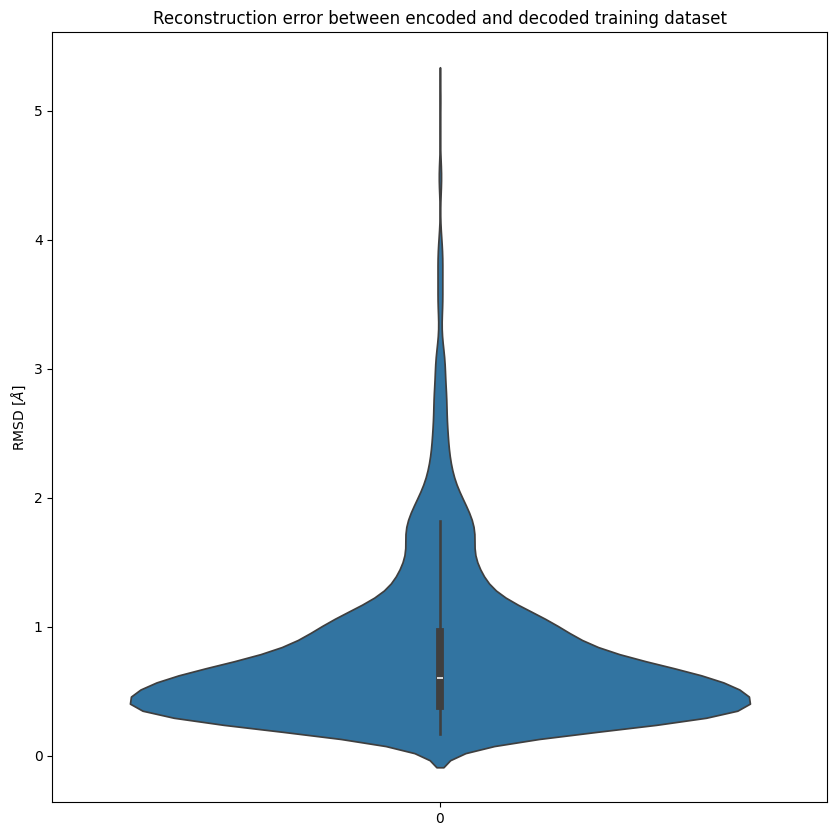

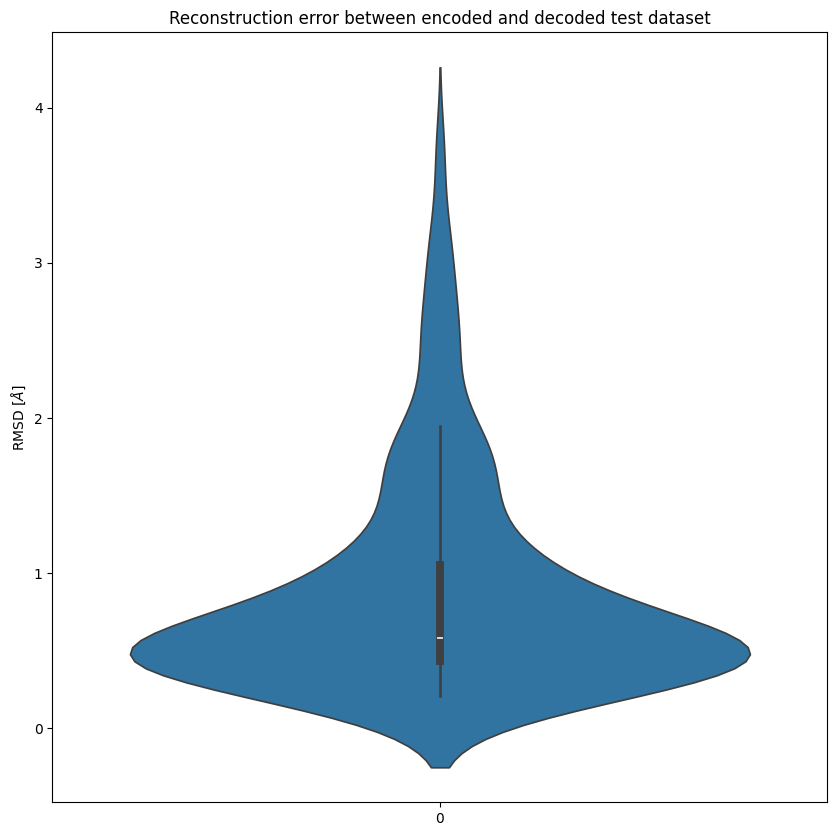

In [ ]:

data = [err_train]
f = plt.figure(figsize=(10, 10))
sns.violinplot(data)
plt.ylabel('RMSD [$\AA$]')
plt.title('Reconstruction error between encoded and decoded training dataset')
plt.show()
f.savefig(f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/err_train_{saveName}.png', dpi=300)

data = [err_test]
f = plt.figure(figsize=(10, 10))
sns.violinplot(data)
plt.ylabel('RMSD [$\AA$]')
plt.title('Reconstruction error between encoded and decoded test dataset')
plt.show()
f.savefig(f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/err_test_{saveName}.png', dpi=300)

Copied outlier (train): Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train/7Q4A_B.pdb -> Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/rmsd_outliers_train/7Q4A_B.pdb
Copied outlier (train): Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train/1BI8_A.pdb -> Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/rmsd_outliers_train/1BI8_A.pdb
Copied outlier (train): Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train/4LG4_B.pdb -> Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/rmsd_outliers_train/4LG4_B.pdb
Copied outlier (train): Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train/1BI8_C.pdb -> Results/run_trial_BRAFActivationLoop_postalign_clea

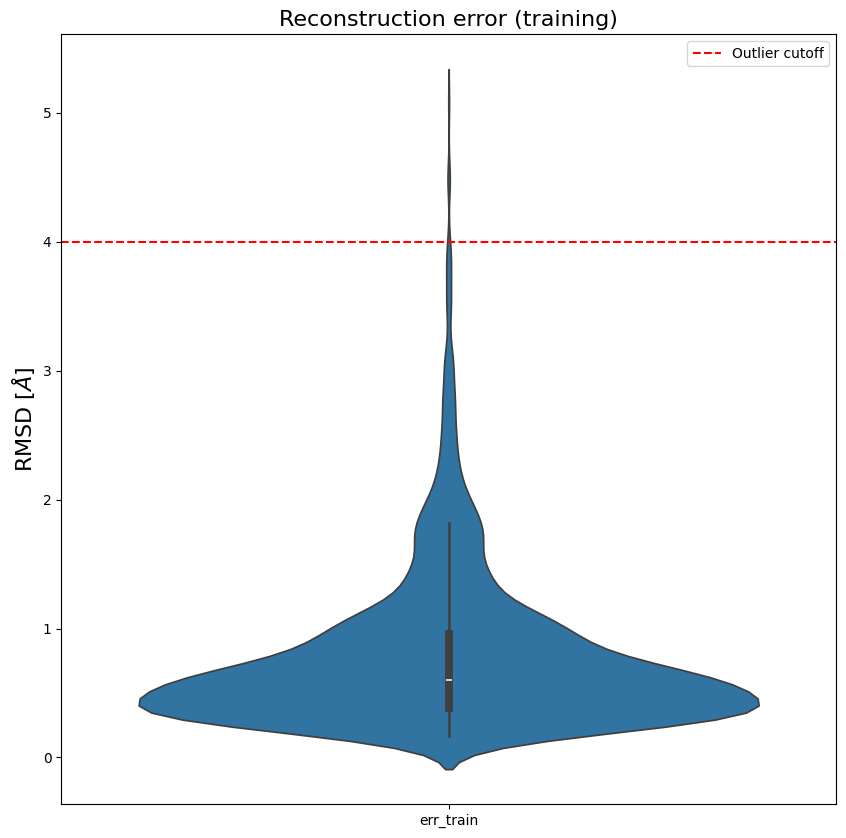

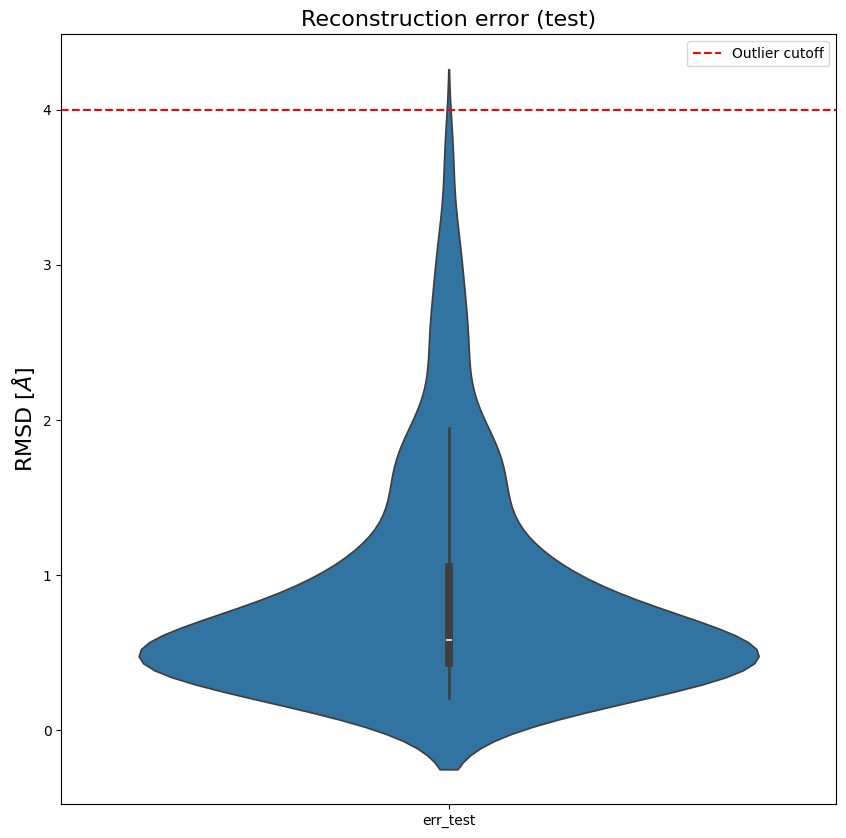

In [ ]:
"""
This script filters out PDB structures with reconstruction errors above a 4 Å RMSD threshold, copies them into separate outlier folders for training and test sets, and visualizes the error distributions using violin plots.

"""
saveName = '_foldingnet_checkpoint'
train_err_csv = f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/err_train_{saveName}.csv'
test_err_csv = f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/err_test_{saveName}.csv'

# Load reconstruction errors from CSV
df_err_train = pd.read_csv(train_err_csv)   
df_err_test = pd.read_csv(test_err_csv)  

#Identify outlier indices with RMSD > 4
train_outlier_indices = df_err_train.index[df_err_train['err_train'] > 4].to_list()
test_outlier_indices = df_err_test.index[df_err_test['err_test'] > 4].to_list()

#Get sorted list of original PDB filenames
folder_name = 'Results/fitted_matlab_segments/mustang_endsAlignment_cleaned_noOutliers'
files = sorted([
    f for f in os.listdir(folder_name)
    if os.path.isfile(os.path.join(folder_name, f)) and f != 'combined.pdb'
])

#Create directories to store outlier PDB files
outlier_dir_train = 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/rmsd_outliers_train'
outlier_dir_test = 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/rmsd_outliers_test'
os.makedirs(outlier_dir_train, exist_ok=True)
os.makedirs(outlier_dir_test, exist_ok=True)

#Copy training outliers into designated folder
source_dir_train = 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_train'
for row_i in train_outlier_indices:
    frame_idx = train_indices[row_i]          
    original_filename = files[frame_idx]     

    src = os.path.join(source_dir_train, original_filename)
    dst = os.path.join(outlier_dir_train, original_filename)

    if os.path.exists(src):
        shutil.copy(src, dst)
        print(f'Copied outlier (train): {src} -> {dst}')
    else:
        print(f'Skipping missing file (train): {src}')

#Copy test outliers into designated folder
source_dir_test = 'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/getDatasetTrial_test'
for row_i in test_outlier_indices:
    frame_idx = test_indices[row_i]
    original_filename = files[frame_idx]

    src = os.path.join(source_dir_test, original_filename)
    dst = os.path.join(outlier_dir_test, original_filename)

    if os.path.exists(src):
        shutil.copy(src, dst)
        print(f'Copied outlier (test): {src} -> {dst}')
    else:
        print(f'Skipping missing file (test): {src}')

#Plot violin plot for training reconstruction errors
f = plt.figure(figsize=(10, 10))
sns.violinplot(data=[df_err_train['err_train']])
plt.axhline(y=4.0, color='red', linestyle='--', label='Outlier cutoff')
plt.legend()
plt.ylabel('RMSD [$\\AA$]', fontsize=16)
plt.title('Reconstruction error (training)', fontsize=16)
plt.show()
f.savefig(f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/err_train_{saveName}.png', dpi=300)

#Plot violin plot for test reconstruction errors
f = plt.figure(figsize=(10, 10))
sns.violinplot(data=[df_err_test['err_test']])
plt.axhline(y=4.0, color='red', linestyle='--', label='Outlier cutoff')
plt.legend()
plt.ylabel('RMSD [$\\AA$]', fontsize=16)
plt.title('Reconstruction error (test)', fontsize=16)
plt.show()
f.savefig(f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/err_test_{saveName}.png', dpi=300)


In [ ]:
MA.setup_grid(30)
landscape_err_latent, landscape_err_3d, xaxis, yaxis = MA.scan_error()
df_landscape_err_latent = pd.DataFrame(landscape_err_latent)
df_landscape_err_latent.to_csv(f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_err_latent_{saveName}.csv', index=False)

df_landscape_err_3d = pd.DataFrame(landscape_err_3d)
df_landscape_err_3d.to_csv(f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_err_3d_{saveName}.csv', index=False)

df_xaxis = pd.DataFrame(xaxis)
df_xaxis.to_csv(f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_err_xaxis_{saveName}.csv', index=False)

df_yaxis = pd.DataFrame(yaxis)
df_yaxis.to_csv(f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_err_yaxis_{saveName}.csv', index=False)

Decoding grid_decoded: 100%|██████████| 113/113 [00:02<00:00, 51.90it/s]


Projection into latent space.

In [ ]:
with torch.no_grad():
    z = net.encode(data_train.dataset)

z_training = z.data.cpu().numpy()[:, :, 0]
df_z_train = pd.DataFrame(z_training)

df_z_train['train_index'] = train_indices

mapping_df = pd.read_csv('train_index_mapping_11_newsplit.csv') 
mapping_dict = mapping_df.set_index('train_index')['pdb_filename'].to_dict()

df_z_train['pdb_filename'] = df_z_train['train_index'].map(mapping_dict)

df_z_train.to_csv(
    f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_encoded_train_coordinates.csv',
    index=False
)


In [ ]:
with torch.no_grad():
    z = net.encode(data_test.dataset)

z_test = z.data.cpu().numpy()[:, :, 0]
df_z_test = pd.DataFrame(z_test)

df_z_test['test_index'] = test_indices

test_mapping_df = pd.read_csv('test_index_mapping_11_newsplit.csv') 
test_mapping_dict = test_mapping_df.set_index('valid_index')['pdb_filename'].to_dict()

df_z_test['pdb_filename'] = df_z_test['test_index'].map(test_mapping_dict)

df_z_test.to_csv(
    f'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_encoded_test_coordinates.csv',
    index=False
)

Train匹配数量: 2186 / 2186
Test匹配数量: 242 / 242


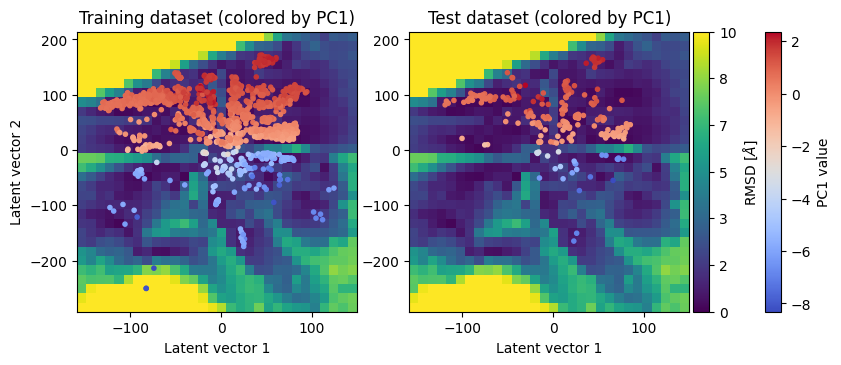

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

# Load precomputed latent space RMSD landscape (X, Y grid and Z values)
x_file = glob.glob("Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_err_xaxis__foldingnet_checkpoint.csv")
y_file = glob.glob("Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_err_yaxis__foldingnet_checkpoint.csv")
z_file = glob.glob("Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_err_latent__foldingnet_checkpoint.csv")

df_x = [pd.read_csv(file, header=None).to_numpy() for file in x_file]
df_y = [pd.read_csv(file, header=None).to_numpy() for file in y_file]
df_z = [pd.read_csv(file).to_numpy() for file in z_file]

df_z=np.squeeze(np.fliplr(df_z))

# Load PC1 values for each structure
pca_df = pd.read_csv(
    'pc1_ends_noOutliers.txt',
    delim_whitespace=True,
    comment='#',
    header=None,
    names=['PC1_value', 'pdb_filename']
)

pca_df['pdb_filename'] = pca_df['pdb_filename'].str.replace('.pdb', '', regex=False)

# Load latent coordinates and clean filenames
latent_train = pd.read_csv(
    'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_encoded_train_coordinates.csv'
)
latent_test = pd.read_csv(
    'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_encoded_test_coordinates.csv'
)

latent_train['pdb_filename'] = latent_train['pdb_filename'].str.replace('.pdb', '', regex=False)
latent_test['pdb_filename'] = latent_test['pdb_filename'].str.replace('.pdb', '', regex=False)

# Merge PC1 values into latent coordinate dataframes
merged_train = pd.merge(latent_train, pca_df, on='pdb_filename', how='inner')
merged_test = pd.merge(latent_test, pca_df, on='pdb_filename', how='inner')

print(f"Train: {len(merged_train)} / {len(latent_train)}")
print(f"Test: {len(merged_test)} / {len(latent_test)}")

# Extract coordinates and PC1 values
x_encoded_train = merged_train.iloc[:, 0]
y_encoded_train = merged_train.iloc[:, 1]
pc1_train = merged_train['PC1_value']

x_encoded_test = merged_test.iloc[:, 0]
y_encoded_test = merged_test.iloc[:, 1]
pc1_test = merged_test['PC1_value']

fig = plt.figure(figsize=(8, 8))

# Plot for training data
ax1 = fig.add_axes([0.0, 0.1, 0.35, 0.35])
ax1.imshow(df_z, cmap='viridis', vmin=0., vmax=10.,
           extent=[np.min(df_x), np.max(df_x), np.min(df_y), np.max(df_y)])
ax1.scatter(x_encoded_train, y_encoded_train, c=pc1_train, marker='.', cmap='coolwarm')
ax1.set_xlabel('Latent vector 1')
ax1.set_ylabel('Latent vector 2')
ax1.set_title('Training dataset (colored by PC1)')
ax1.set_aspect('auto')  

# Plot for test data
ax2 = fig.add_axes([0.415, 0.1, 0.35, 0.35])
im = ax2.imshow(df_z, cmap='viridis', vmin=0., vmax=10.,
                extent=[np.min(df_x), np.max(df_x), np.min(df_y), np.max(df_y)])
ax2.scatter(x_encoded_test, y_encoded_test, c=pc1_test, marker='.', cmap='coolwarm')
ax2.set_xlabel('Latent vector 1')
ax2.set_title('Test dataset (colored by PC1)')
ax2.set_aspect('auto')  


# RMSD colorbar
cbar_ax2 = fig.add_axes([0.77, 0.1, 0.02, 0.35])
cbar_ax2.tick_params(left=False, labelleft=False, right=True, labelright=True, labelbottom=False, bottom=False)
cbar = fig.colorbar(im, cax=cbar_ax2, label='RMSD [$\AA$]')
cbar_ticks = np.linspace(0, 10, 7)
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels([f'{tick:.0f}' for tick in cbar_ticks])

# PC1 colorbar
cbar_ax_pca = fig.add_axes([0.86, 0.1, 0.02, 0.35])
pca_norm = plt.Normalize(vmin=min(pc1_train.min(), pc1_test.min()),
                         vmax=max(pc1_train.max(), pc1_test.max()))
cbar_pca = fig.colorbar(
    plt.cm.ScalarMappable(norm=pca_norm, cmap='coolwarm'),
    cax=cbar_ax_pca,
    label='PC1 value'
)

plt.savefig(
    'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/RMSDlandscapesOnePlot_coloredByPC1.png',
    dpi=300, bbox_inches='tight'
)
plt.show()

Train匹配数量: 2186 / 2186
Test匹配数量: 242 / 242


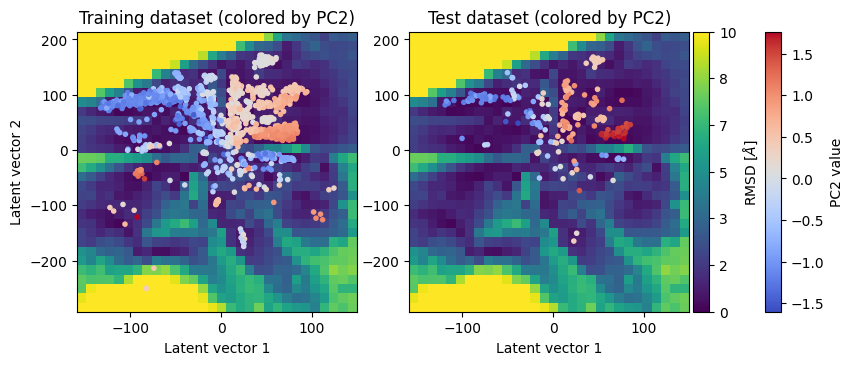

In [ ]:
"""
Same as before but using PC2 to color the points 
"""
import pandas as pd
import matplotlib.pyplot as plt
import glob

x_file = glob.glob("Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_err_xaxis__foldingnet_checkpoint.csv")
y_file = glob.glob("Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_err_yaxis__foldingnet_checkpoint.csv")
z_file = glob.glob("Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_err_latent__foldingnet_checkpoint.csv")

df_x = [pd.read_csv(file, header=None).to_numpy() for file in x_file]
df_y = [pd.read_csv(file, header=None).to_numpy() for file in y_file]
df_z = [pd.read_csv(file).to_numpy() for file in z_file]

df_z=np.squeeze(np.fliplr(df_z))

pca_df = pd.read_csv(
    'pc2_ends_noOutliers.txt',
    delim_whitespace=True,
    comment='#',
    header=None,
    names=['PC1_value', 'pdb_filename']
)

pca_df['pdb_filename'] = pca_df['pdb_filename'].str.replace('.pdb', '', regex=False)

latent_train = pd.read_csv(
    'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_encoded_train_coordinates.csv'
)
latent_test = pd.read_csv(
    'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/landscape_encoded_test_coordinates.csv'
)

latent_train['pdb_filename'] = latent_train['pdb_filename'].str.replace('.pdb', '', regex=False)
latent_test['pdb_filename'] = latent_test['pdb_filename'].str.replace('.pdb', '', regex=False)

merged_train = pd.merge(latent_train, pca_df, on='pdb_filename', how='inner')
merged_test = pd.merge(latent_test, pca_df, on='pdb_filename', how='inner')

print(f"Train匹配数量: {len(merged_train)} / {len(latent_train)}")
print(f"Test匹配数量: {len(merged_test)} / {len(latent_test)}")

x_encoded_train = merged_train.iloc[:, 0]
y_encoded_train = merged_train.iloc[:, 1]
pc1_train = merged_train['PC1_value']

x_encoded_test = merged_test.iloc[:, 0]
y_encoded_test = merged_test.iloc[:, 1]
pc1_test = merged_test['PC1_value']

fig = plt.figure(figsize=(8, 8))

ax1 = fig.add_axes([0.0, 0.1, 0.35, 0.35])
ax1.imshow(df_z, cmap='viridis', vmin=0., vmax=10.,
           extent=[np.min(df_x), np.max(df_x), np.min(df_y), np.max(df_y)])
ax1.scatter(x_encoded_train, y_encoded_train, c=pc1_train, marker='.', cmap='coolwarm')
ax1.set_xlabel('Latent vector 1')
ax1.set_ylabel('Latent vector 2')
ax1.set_title('Training dataset (colored by PC2)')
ax1.set_aspect('auto')  

ax2 = fig.add_axes([0.415, 0.1, 0.35, 0.35])
im = ax2.imshow(df_z, cmap='viridis', vmin=0., vmax=10.,
                extent=[np.min(df_x), np.max(df_x), np.min(df_y), np.max(df_y)])
ax2.scatter(x_encoded_test, y_encoded_test, c=pc1_test, marker='.', cmap='coolwarm')
ax2.set_xlabel('Latent vector 1')
ax2.set_title('Test dataset (colored by PC2)')
ax2.set_aspect('auto')  

cbar_ax2 = fig.add_axes([0.77, 0.1, 0.02, 0.35])
cbar_ax2.tick_params(left=False, labelleft=False, right=True, labelright=True, labelbottom=False, bottom=False)
cbar = fig.colorbar(im, cax=cbar_ax2, label='RMSD [$\AA$]')
cbar_ticks = np.linspace(0, 10, 7)
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels([f'{tick:.0f}' for tick in cbar_ticks])

cbar_ax_pca = fig.add_axes([0.86, 0.1, 0.02, 0.35])
pca_norm = plt.Normalize(vmin=min(pc1_train.min(), pc1_test.min()),
                         vmax=max(pc1_train.max(), pc1_test.max()))
cbar_pca = fig.colorbar(
    plt.cm.ScalarMappable(norm=pca_norm, cmap='coolwarm'),
    cax=cbar_ax_pca,
    label='PC2 value'
)

plt.savefig(
    'Results/run_trial_BRAFActivationLoop_postalign_cleaned_noOutlier_11_checkpoint_newsplit/RMSDlandscapesOnePlot_coloredByPC2.png',
    dpi=300, bbox_inches='tight'
)
plt.show()